# **Loan Default Prediction**
![Loan image](https://s28637.pcdn.co/wp-content/uploads/2019/07/past-due--980x654.jpg)

## **Problem Statement**
Small Business Administration(SBA) is an agency of the Federal Government that exists to serve, support, and protect the interests of small businesses. One way SBA assist these small business enterprises is through a loan guarantee program which is designed to encourage the bank to grant loans to small business. But, since SBA loans only guarantee a portion of the entire loan balance, banks will incur some losses if a small business defaults on its SBA-guaranteed loan. Therefore, banks are still faced with a difficult choice as to whether they should grant such a loan because of the high risk of default. One way to uniform their decision-making is through analyzing relevant historical data.

In this project we analysed the historical data from the U.S.SBA loan database and built a machine learning model to predict whether a loan backed by the Small Business Administration (SBA) government agency will pay off in full or default. 







**Author: Luis Fernando Salazar Salinas Date: 18/05/2022**

### **Loan Default Dataset**

The original data set is from the U.S.SBA loan database, which includes historical data from 1987 through 2014 (899,164 observations) with 27 variables. The data set includes information on whether the loan was paid off in full or if the SBA had to charge off any amount and how much that amount was. 

According to Li, Mickel, & Taylor 2018, the project filtered the  original dataset to California State and  add the following new variables:

- New
- Portion 
- RealEstate
- Recession
- Default(Target)


For more information on this data set, visit the follow url: https://amstat.tandfonline.com/doi/full/10.1080/10691898.2018.1434342

### **Install and Import the libraries**

In [1]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 778 kB/s 


In [2]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
!pip install MarkupSafe==2.0.1

In [3]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 40 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [6]:
## importing the libraries
import os 
import warnings
warnings.simplefilter(action ="ignore")
#import wget
import joblib

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import missingno as msno

import numpy as np
import pandas as pd
import scipy

#from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb

In [7]:
xgb.__version__

'1.6.2'

### **Get the dataset**

In [8]:
## Conect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# get data
def get_data(filepath):

  df = pd.read_csv(filepath)

  # Mask for California State
  mask = df['State'] == 'CA'
  df = df[mask]

  return df

### **Exploratory Data Analysis**

- Structure
- Content 
- Patterns 
- Visial analysis
  - Loan Status during Recessesion
  - Loan Status Backed by Real Estate
  - Loan Status by Gross Disbursement
  - Loan Status by the SBA’s Guaranteed Amount of Approved
  - Frequency of loan default/pif by industry

#### Structure

In [10]:
df = get_data('/content/drive/MyDrive/Loan_Default/SBAnational.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130619 entries, 28 to 899161
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   LoanNr_ChkDgt        130619 non-null  int64  
 1   Name                 130619 non-null  object 
 2   City                 130613 non-null  object 
 3   State                130619 non-null  object 
 4   Zip                  130619 non-null  int64  
 5   Bank                 130481 non-null  object 
 6   BankState            130480 non-null  object 
 7   NAICS                130619 non-null  int64  
 8   NAICS_2DIG           101918 non-null  float64
 9   Industry_definition  101918 non-null  object 
 10  ApprovalDate         130619 non-null  object 
 11  ApprovalFY           130619 non-null  object 
 12  Term                 130619 non-null  int64  
 13  NoEmp                130619 non-null  int64  
 14  NewExist             130608 non-null  float64
 15  New             

In [ ]:
print(f"Data dimensionality {df.shape}")
df.head(10)

Data dimensionality (130619, 30)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,NAICS_2DIG,Industry_definition,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
28,1000506000,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,611110,61.0,Educational Services,...,Y,N,NaN,28-feb-06,"$438,541.00",$0.00,P I F,$0.00,"$100,000.00","$50,000.00"
48,1000685001,ANYWHERE SPORTS PRODUCTIONS,Marina del Ray,CA,90292,WELLS FARGO BANK NATL ASSOC,SD,0,NaN,NaN,...,Y,N,NaN,31-oct-97,"$30,570.00",$0.00,P I F,$0.00,"$25,000.00","$12,500.00"
55,1000715008,John Dailey,Castro Valley,CA,94546,WELLS FARGO BANK NATL ASSOC,SD,0,NaN,NaN,...,0,N,NaN,31-may-99,"$15,000.00",$0.00,P I F,$0.00,"$15,000.00","$7,500.00"
62,1000746002,ANGEL,LOS ANGELES,CA,60014,BBCN BANK,CA,315212,31.0,Manufacturing,...,0,N,NaN,28-feb-06,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$17,500.00"
63,1000754002,"MCCRANEY, INC.",SANTA ANA,CA,92703,BANK OF THE WEST,CA,0,NaN,NaN,...,0,N,NaN,31-mar-97,"$745,000.00",$0.00,P I F,$0.00,"$745,000.00","$558,750.00"
69,1000775004,Larry P. Occhipinti,Patterson,CA,95363,WELLS FARGO BANK NATL ASSOC,SD,541940,54.0,"Professional, Scientific, and Technical Services",...,0,N,NaN,31-oct-97,"$18,107.00",$0.00,P I F,$0.00,"$20,000.00","$10,000.00"
70,1000785007,Baltazar Garza,Fresno,CA,93612,WELLS FARGO BANK NATL ASSOC,SD,811111,81.0,Other Services,...,0,N,NaN,31-Aug-02,"$10,000.00",$0.00,P I F,$0.00,"$10,000.00","$5,000.00"
72,1000794003,"STEVENSON PEST CONTROL, INC.",YUBA CITY,CA,95992,GOLDEN PACIFIC BANK NATL ASSOC,CA,0,NaN,NaN,...,N,N,NaN,30-jun-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
77,1000816010,TULON PACIFIC LLC,IRVINE,CA,92618,WELLS FARGO BANK NATL ASSOC,SD,423710,42.0,Wholesale Trade,...,Y,N,NaN,31-mar-06,"$577,000.00",$0.00,P I F,$0.00,"$300,000.00","$150,000.00"
80,1000826002,GUADALAJARA DISTRIBUTORS,NORTH HILLS,CA,91343,BBCN BANK,CA,514199,51.0,Information,...,0,N,NaN,28-feb-06,"$5,000.00",$0.00,P I F,$0.00,"$5,000.00","$4,250.00"


In [ ]:
# Unique value by categorical variables
df.describe(include = "object").T

,count,unique,top,freq
Name,130619,117854,"Meathead Movers, Inc.",89
City,130613,3101,LOS ANGELES,11557
State,130619,1,CA,130619
Bank,130481,508,WELLS FARGO BANK NATL ASSOC,16288
BankState,130480,50,CA,76477
Industry_definition,101918,20,Retail Trade,18198
ApprovalDate,130619,7355,6-jul-93,166
ApprovalFY,130619,54,2007,11233
RevLineCr,130115,7,N,52277
LowDoc,130448,7,N,124536


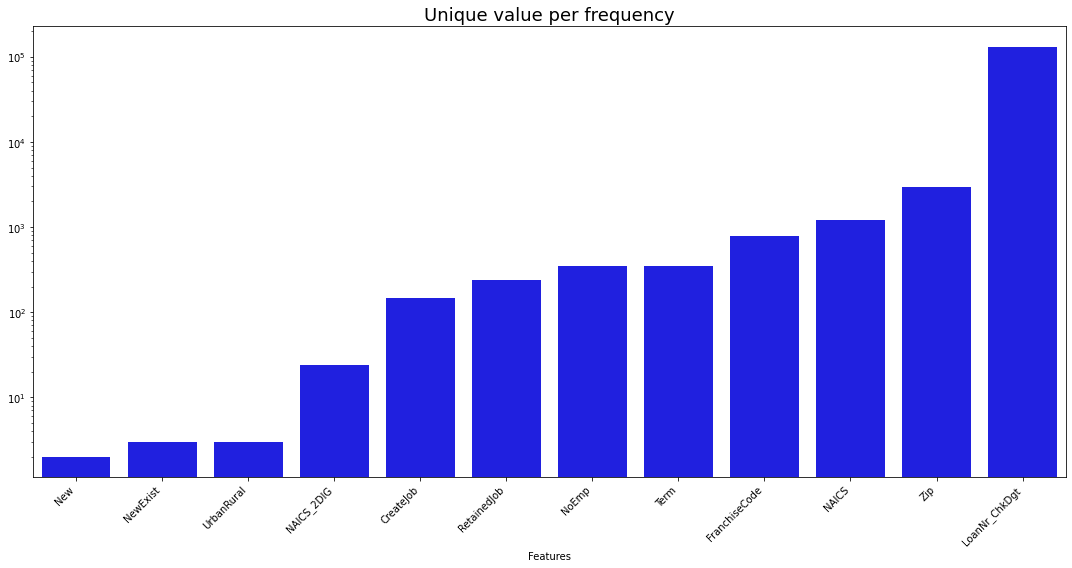

In [ ]:
# unique values by numerical variable
unique_values = df.select_dtypes("number").nunique().sort_values()

# bar Plot
fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(x = unique_values.index, y = unique_values, color = 'Blue', ax = ax)
ax.set_yscale("log")
ax.set_xlabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Unique value per frequency", fontsize = 18)

plt.tight_layout();

#### Quality
 - Missing values 
 - Outliers
 - Duplicates observation

In [ ]:
# Detection duplicate value
duplicate_value = df.duplicated().sum()

print(f"In this dataset there are {duplicate_value} duplicate values")

In this dataset there are 0 duplicate values


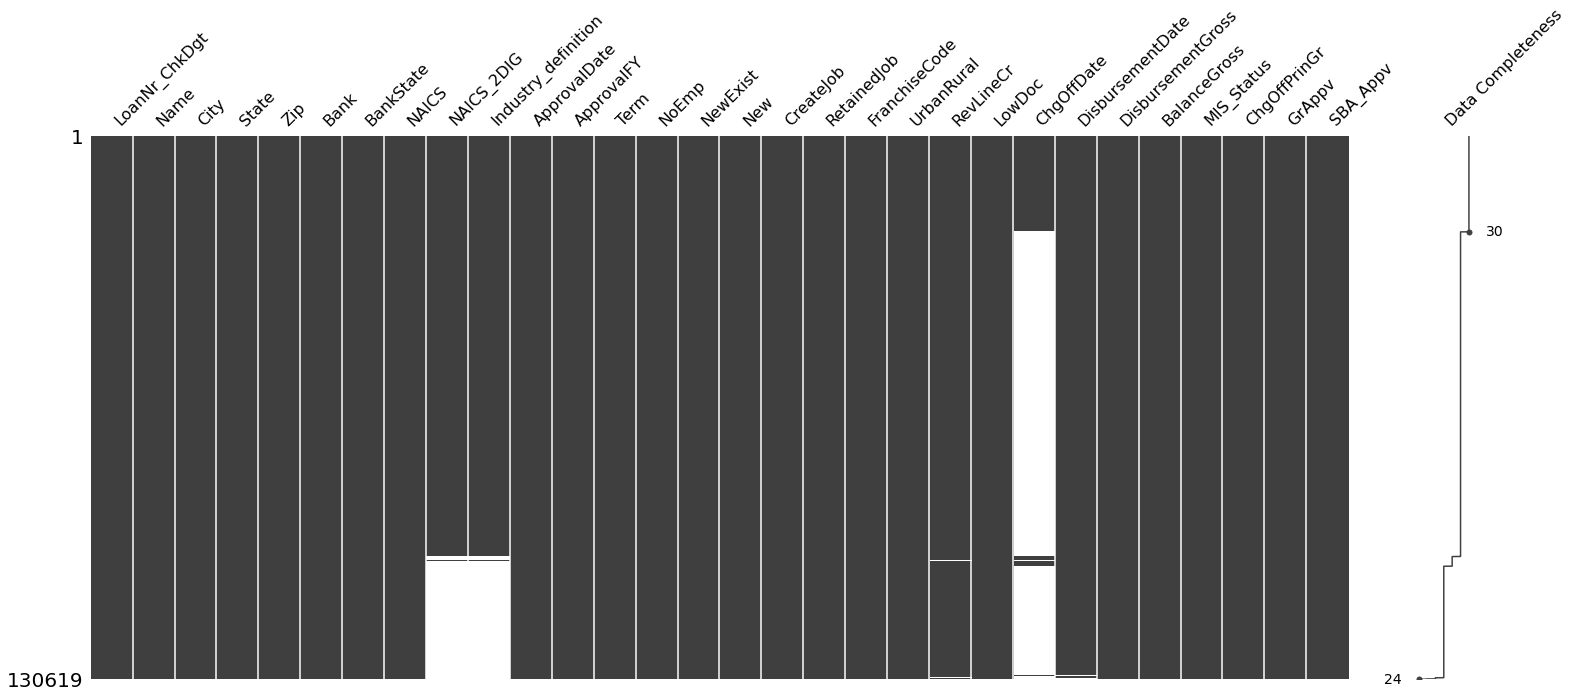

In [ ]:
## Missing values by samples
msno.matrix(df, labels = True, sort = "descending");

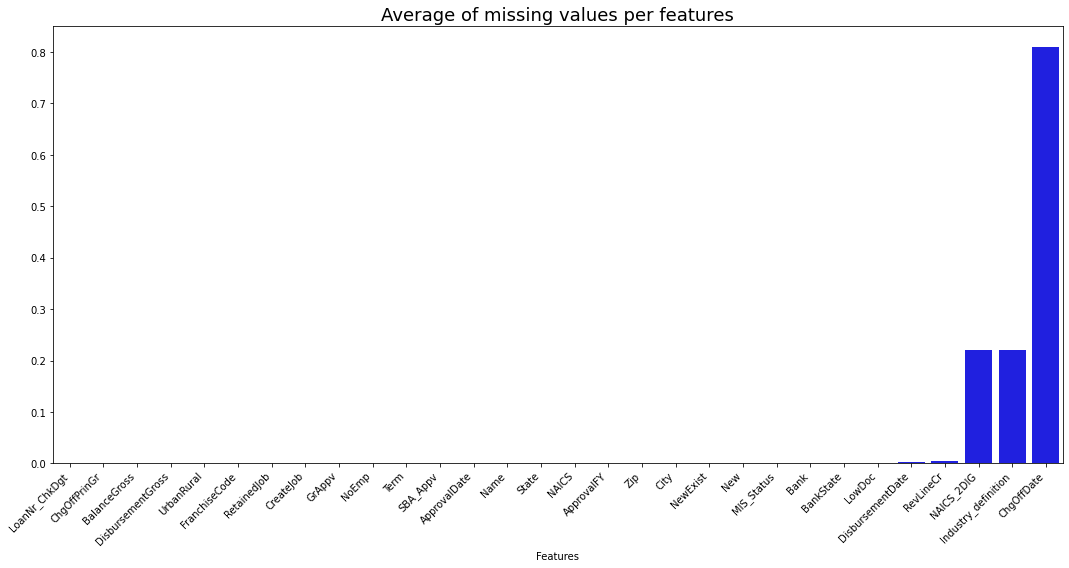

In [ ]:
# Missing vlaues by Features
avg_missing = (
    df
    .isnull()
    .mean()
    .sort_values()
)

# bar plot
fig, ax = plt.subplots(figsize = (15, 8))
sns.barplot(x = avg_missing.index, y = avg_missing, color = 'blue', ax = ax )
ax.set_xlabel("Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Average of missing values per features", fontsize = 18)

plt.tight_layout();

In [11]:
def wrangle(df):
  # copy
  df_c = df.copy(deep = True)
  
  ## Remove symbols 
  list_s = ['DisbursementGross','GrAppv','SBA_Appv']

  for colm in list_s:
    df_c[colm] = df_c[colm].str.replace('[$,]', '').astype(float)
    
        
  ## List of unnecessary, inconsistent and leaky variables
  list_un = ['LoanNr_ChkDgt','Name','City','State', 'Zip','Bank',
              'BankState','NAICS','ApprovalDate','NewExist',
              'ApprovalFY', 'FranchiseCode','ChgOffPrinGr','ChgOffDate',
              'BalanceGross','RevLineCr','LowDoc','CreateJob','RetainedJob','UrbanRural'
              ]
     
  ## Maintain the 10 cities with the most information and classify the other cities as others
  #ten_cities = df['City'].value_counts().head(10).index
  #df['City'] = df['City'].apply(lambda c : c if c in ten_cities else 'Others')
    
  ## Setting the DisbursementDate
  df_c['DisbursementDate'] = pd.to_datetime(df_c['DisbursementDate']).astype(str)
  df_c['DisbursementDate'] = df_c['DisbursementDate'].str.split('-', expand = True)[0]
    
  ## Create Recession variable
  list_rece = []
    
  for rece in df_c['DisbursementDate']:
    if rece >= '2007' and rece <= '2009':
      rece = 1
    else:
      rece = 0
    
    list_rece.append(rece)
    
  df_c['Recession'] = list_rece
    
  list_un.append('DisbursementDate')
    
    
  # Create a Real State variable 
  list_real = []
    
  for real in df_c['Term']:
    if real >=240:
      real = 1
    else:
      real = 0

    list_real.append(real)
        
  df_c['RealEstate'] = list_real
    

  # SBA's Guaranteed Portion of Approved Loan
  df_c['portion'] = df_c['SBA_Appv']/ df_c['GrAppv']
    
    
  # New target variable
  df_c['Default'] = (df_c['MIS_Status'] == 'CHGOFF').astype(int)
    
  #Remove old target variable
  list_un.append('MIS_Status')
    
  # Drop columns
  df_c.drop(columns = list_un, inplace = True)

  # drop miss_values
  df_c.dropna(inplace = True)
     
  return df_c

In [12]:
# Cleaning 
df_tran = wrangle(df)
print(df_tran.shape)
df_tran.head(4)

(101841, 12)


,NAICS_2DIG,Industry_definition,Term,NoEmp,New,DisbursementGross,GrAppv,SBA_Appv,Recession,RealEstate,portion,Default
28,61.0,Educational Services,83,18,1.0,438541.0,100000.0,50000.0,0,0,0.5,0
62,31.0,Manufacturing,36,20,1.0,35000.0,35000.0,17500.0,0,0,0.5,0
69,54.0,"Professional, Scientific, and Technical Services",84,2,0.0,18107.0,20000.0,10000.0,0,0,0.5,0
70,81.0,Other Services,84,3,0.0,10000.0,10000.0,5000.0,0,0,0.5,0


#### **Visual analysis**

##### **Recession**

In [ ]:
### Ressecion analysis 
## Proportions of loan paid in full during recession
default_reces = pd.DataFrame()
default_reces['Loan Paid in Full'] = (
    df_tran[(df_tran['Default'] == 0) ].groupby('Recession')['Default'].count()/
    df_tran.groupby('Recession')['Default'].count()
)
## Proportions of loan default during recession
default_reces['Loan Default'] = (
    df_tran[(df_tran['Default'] == 1) ].groupby('Recession')['Default'].count()/
    df_tran.groupby('Recession')['Default'].count()
)

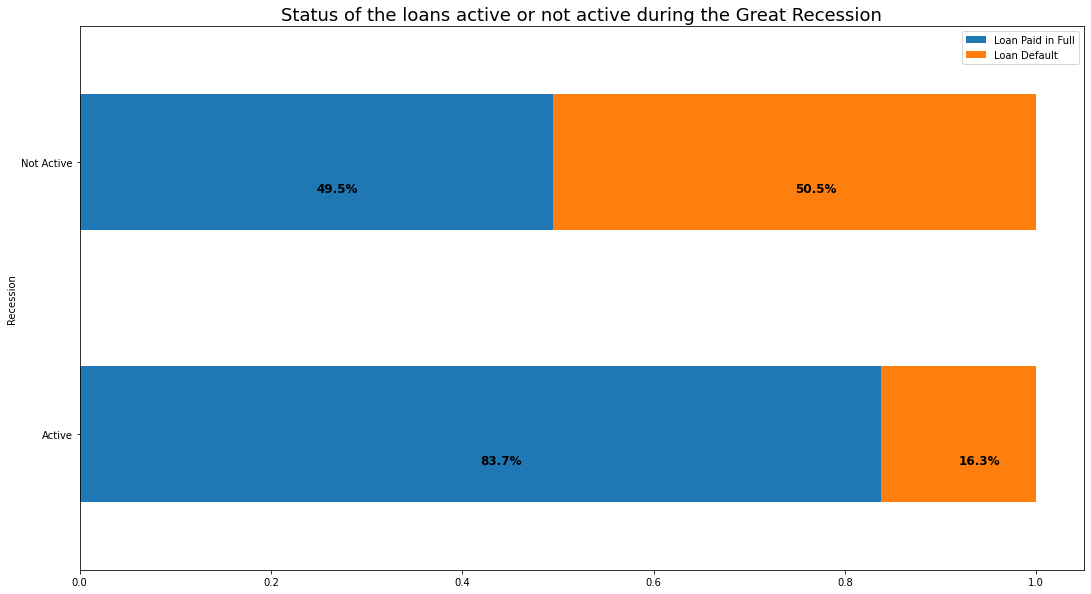

In [ ]:
fig, ax = plt.subplots(figsize = (18,10))
default_reces.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Status of the loans active or not active during the Great Recession', fontsize = 18)
plt.legend(loc = 'upper right')

for n, x in enumerate([*default_reces.index.values]):
    for (proportion, y_loc) in zip(default_reces.loc[x],
                                   default_reces.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
        
ax.yaxis.set_ticklabels(['Active','Not Active'])

plt.show()

 ###### **Observations**

 - By the analysis of the state of credits during the recession period, we can see that 50.6% of the credits were not paid in full and 49.4% were paid in full This reflects the impact that the economic recession period had on the economy of the US industries because when we analyze the credits that were not activated in the period of economic recession, we can see that 86.5% of the credits were paid in full and only 13.5% of the credits were not paid completely.



##### **Real Estate**

In [ ]:
### Ressecion analysis 
default_rst = pd.DataFrame()
## Proportions of loan paid in full during recession
default_rst['Loan Paid in Full'] = (
    df_tran[(df_tran['Default'] == 0.0) ].groupby('RealEstate')['Default'].count()/
    df_tran.groupby('RealEstate')['Default'].count()
)
## Proportions of loan default during recession
default_rst['Loan Default'] = (
    df_tran[(df_tran['Default'] == 1.0) ].groupby('RealEstate')['Default'].count()/
    df_tran.groupby('RealEstate')['Default'].count()
)

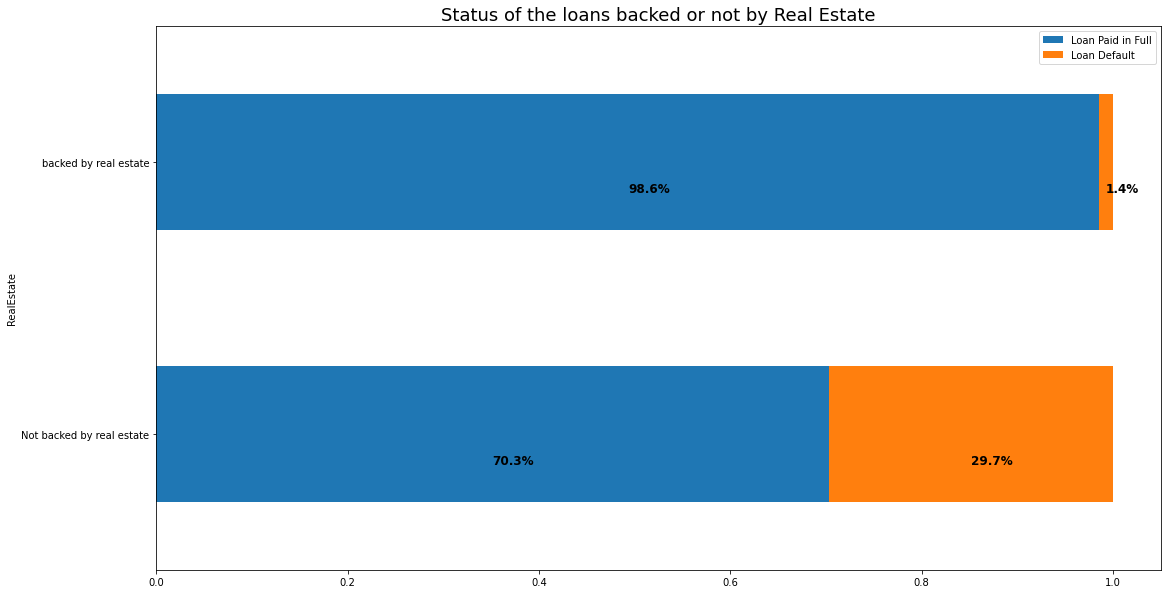

In [ ]:
fig, ax = plt.subplots(figsize = (18,10))
default_rst.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Status of the loans backed or not by Real Estate', fontsize = 18)
plt.legend(loc = 'upper right')

for n, x in enumerate([*default_rst.index.values]):
    for (pro, y_loc) in zip(default_rst.loc[x],
                            default_rst.loc[x].cumsum()):
                
        plt.text(x=(y_loc - pro) + (pro / 2),
                 y=n - 0.11,
                 s=f'{np.round(pro * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
        

ax.yaxis.set_ticklabels(['Not backed by real estate','backed by real estate'])

plt.show()

###### **Observations**
- 98.8% of the loans backed for real estate were paid in full, while 1.2% were not paid in full. In this sense, the pattern shown in the chart reflects the importance that has this type of financial security.

##### **Loan Status**

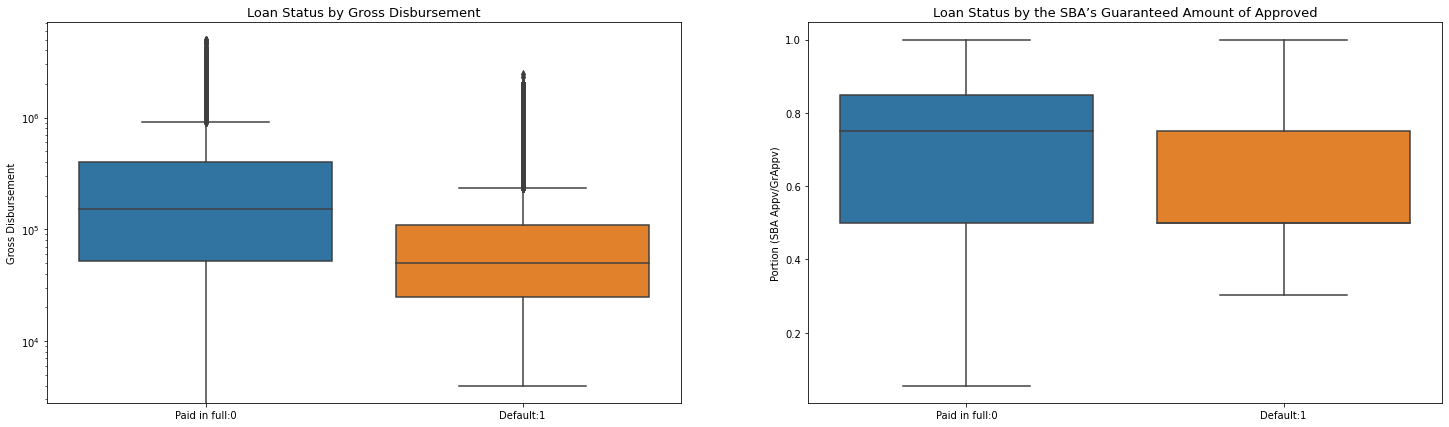

In [ ]:
fig = plt.figure(figsize =(25,7))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Gross Disbursement vs Default plot
sns.boxplot(x=df_tran['Default'], y=df_tran['DisbursementGross'], ax = ax0)
ax0.set_xlabel('')
ax0.set_yscale("log")
ax0.set_ylabel('Gross Disbursement')
ax0.set_title('Loan Status by Gross Disbursement', fontsize = 13)
ax0.xaxis.set_ticklabels(["Paid in full:0", "Default:1"])

# Portion vs Default plot
sns.boxplot(x=df_tran['Default'], y=df_tran['portion'] , ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Portion (SBA Appv/GrAppv)')
ax1.xaxis.set_ticklabels(["Paid in full:0", "Default:1"])
ax1.set_title('Loan Status by the SBA’s Guaranteed Amount of Approved',fontsize = 13);

 ###### **Observations**
 - The box plot of Loan Status by Gross Disbursement shows us that i) there are presence of outliers and ii) the median of the loans paid in full is greater than of the loans defaulted, to a greater amount of Gross Disbursement by banks.

- The box plot of Loan Status by the SBA’s Guaranteed Amount of Approved shows us that a higher percentage of money covered by the SBA could help reduce the rate of credit defaults by companies.

##### **Industries**

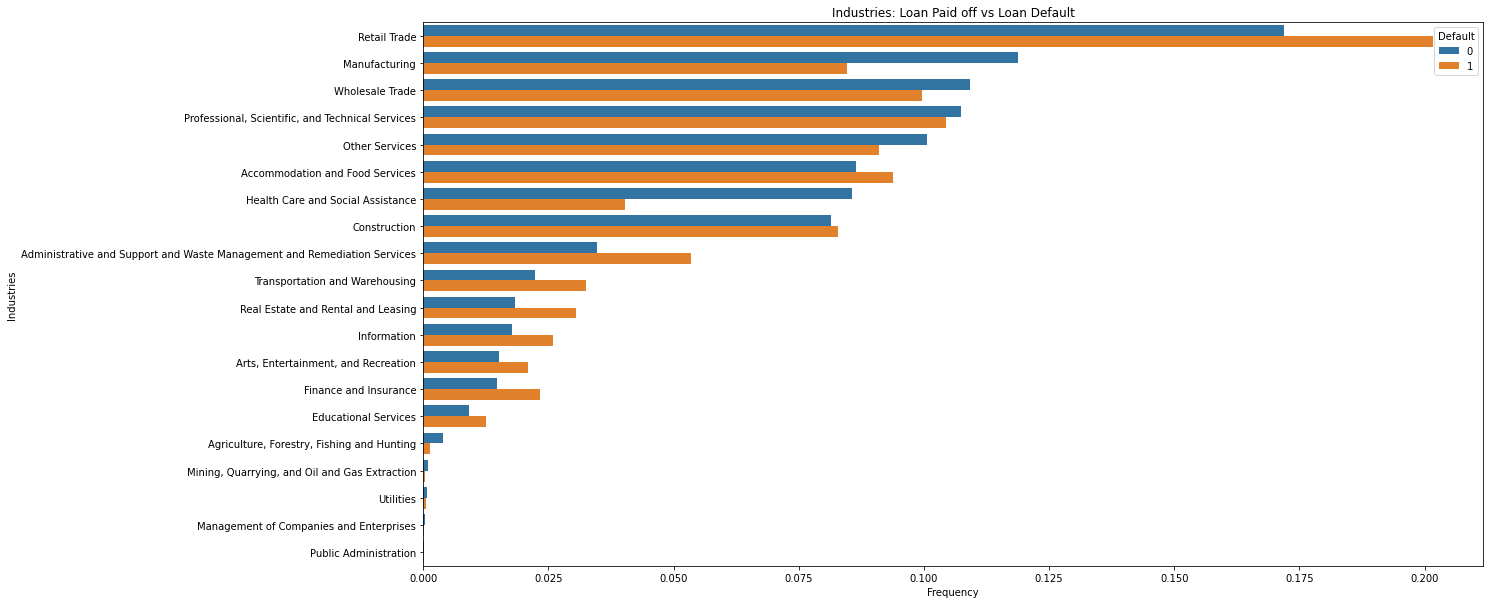

In [ ]:
##
indu_status =(
    df_tran['Industry_definition']
    .groupby(df_tran['Default'])
    .value_counts(normalize = True)
    .rename('Frequency')
    .to_frame()
    .reset_index()
)
#Plot
fig, ax = plt.subplots(figsize = (19,10))

sns.barplot(data = indu_status,
            x = 'Frequency',
            y = 'Industry_definition',
            hue = 'Default',
            ax = ax
            )

ax.set(xlabel = 'Frequency',
       ylabel = 'Industries',
       title =  'Industries: Loan Paid off vs Loan Default'
);

In [13]:
# drop Industry_definition variable
df_tran.drop(columns = 'Industry_definition', inplace = True)

In [ ]:
## Save clean dataset
df.to_csv('SBAnational_clean.csv', index= False)

#### **Content**

##### Data distributions and summary statistic

In [ ]:
df_tran.describe().T

,count,mean,std,min,25%,50%,75%,max
NAICS_2DIG,101841.0,50.862118,16.529496,11.000,42.0,48.00,62.00,92.0
Term,101841.0,129.365864,93.629617,0.000,64.0,84.00,240.00,527.0
NoEmp,101841.0,11.890133,64.666455,0.000,2.0,5.00,10.00,8041.0
New,101841.0,0.165739,0.371848,0.000,0.0,0.00,0.00,1.0
DisbursementGross,101841.0,259078.353433,350718.148437,0.000,49710.0,120000.00,330000.00,5000000.0
GrAppv,101841.0,251055.247749,352683.383625,1000.000,35000.0,100000.00,322000.00,5000000.0
SBA_Appv,101841.0,197481.860852,292240.995134,500.000,20000.0,75000.00,255500.00,5000000.0
Recession,101841.0,0.172966,0.378219,0.000,0.0,0.00,0.00,1.0
RealEstate,101841.0,0.265011,0.441341,0.000,0.0,0.00,1.00,1.0
portion,101841.0,0.694797,0.175564,0.056,0.5,0.75,0.85,1.0


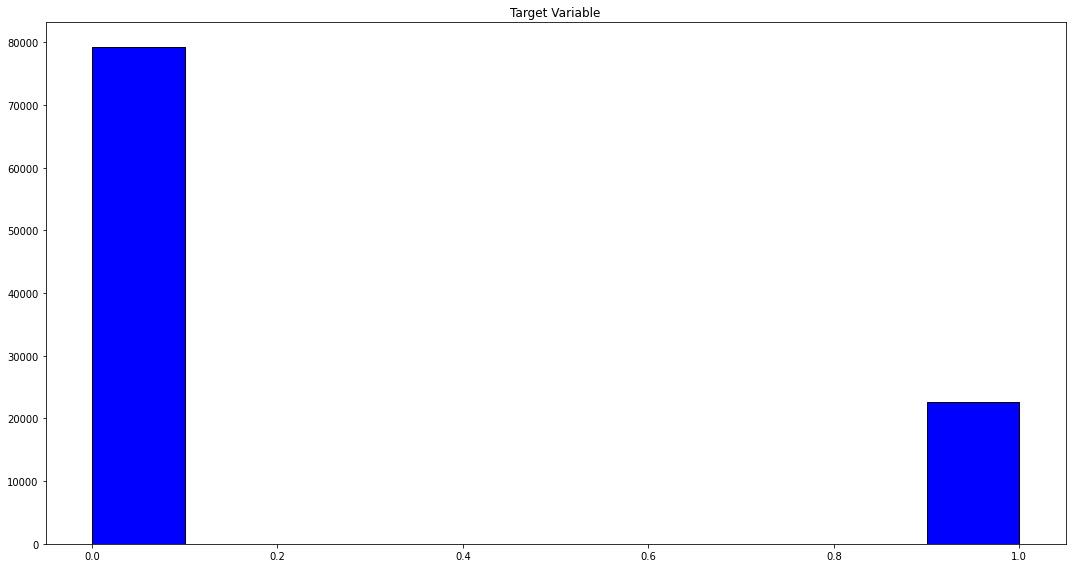

In [ ]:
# Target distribution
df_tran['Default'].hist(figsize = (15, 8),
                       color = "blue",
                       grid = False,
                       edgecolor = "black")

plt.title("Target Variable")
plt.tight_layout();

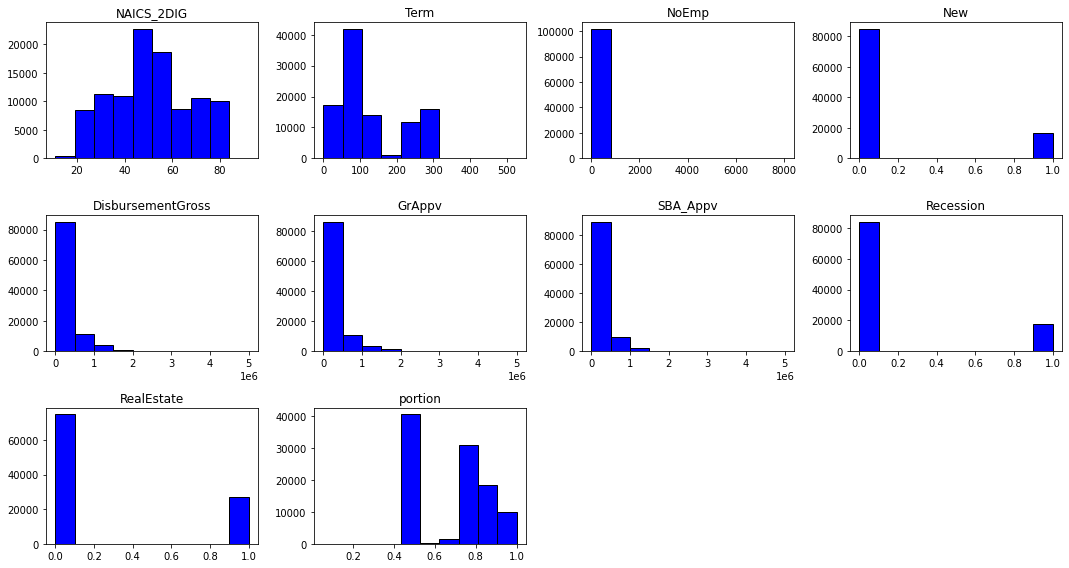

In [ ]:
# Feature distributions
df_tran.drop(columns = 'Default').hist(bins = 10,
                                      figsize = (15, 8),
                                      layout = (-1, 4),
                                      grid = False,
                                      color = "blue",
                                      edgecolor = "black",
                                      )
plt.tight_layout();

In [ ]:
# Kurtosis and skew
num_features = [colm for colm in df_tran.select_dtypes("number").columns if colm != "Default"]

for col in num_features:
    kurt = scipy.stats.mstats.kurtosis(df_tran[col])
    Skew = scipy.stats.mstats.skew(df_tran[col])
    
    print(f"{col} Skew: {np.round(Skew, 2)}, Kurtosis: {np.round(kurt, 2)}")

NAICS_2DIG Skew: 0.21, Kurtosis: -0.63
Term Skew: 0.8, Kurtosis: -0.81
NoEmp Skew: 75.77, Kurtosis: 7416.48
New Skew: 1.8, Kurtosis: 1.23
DisbursementGross Skew: 2.85, Kurtosis: 13.06
GrAppv Skew: 2.8, Kurtosis: 12.25
SBA_Appv Skew: 2.98, Kurtosis: 15.25
Recession Skew: 1.73, Kurtosis: 0.99
RealEstate Skew: 1.06, Kurtosis: -0.87
portion Skew: 0.13, Kurtosis: -1.3


##### Patters
- Pairplots
- Correlation coefficient
 - Pearson
 - Spearman

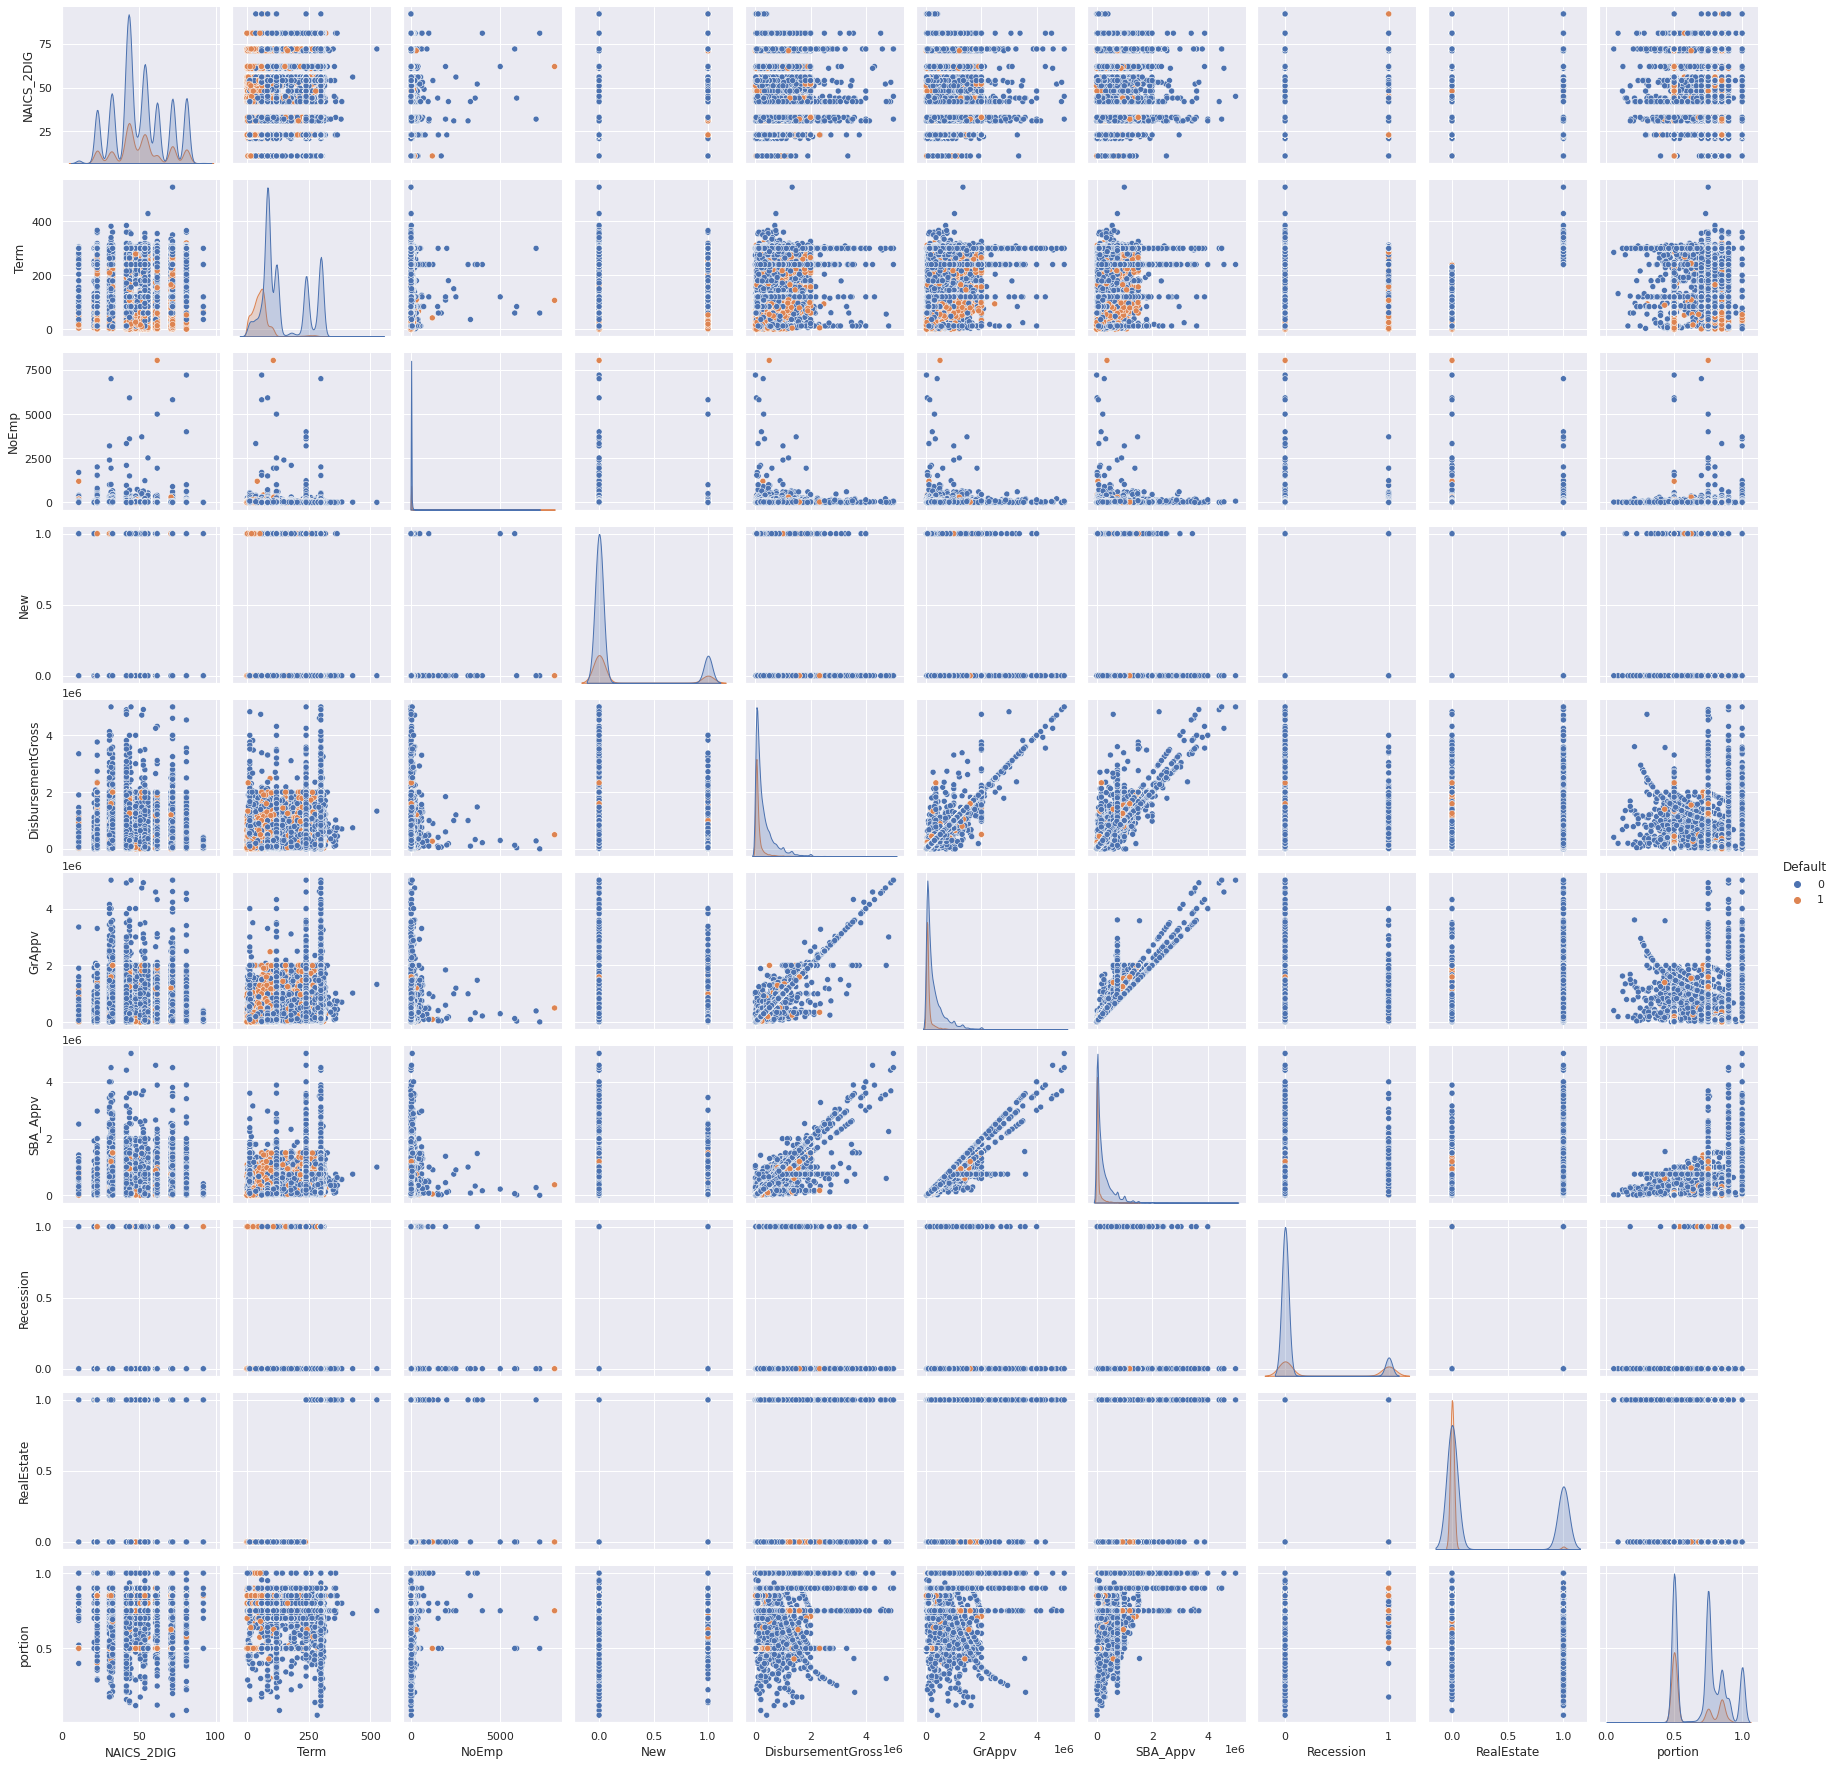

In [ ]:
## pairplot
sns.set(rc={'figure.figsize':(14,8)})
sns.pairplot(df_tran, hue = 'Default')
sns.set_context('talk')
sns.set_style('white')

In [ ]:
## Correlaction (pearson and spermean)
pearson_corr = df_tran.corr(method = 'pearson')
spearman_corr = df_tran.corr(method = 'spearman')

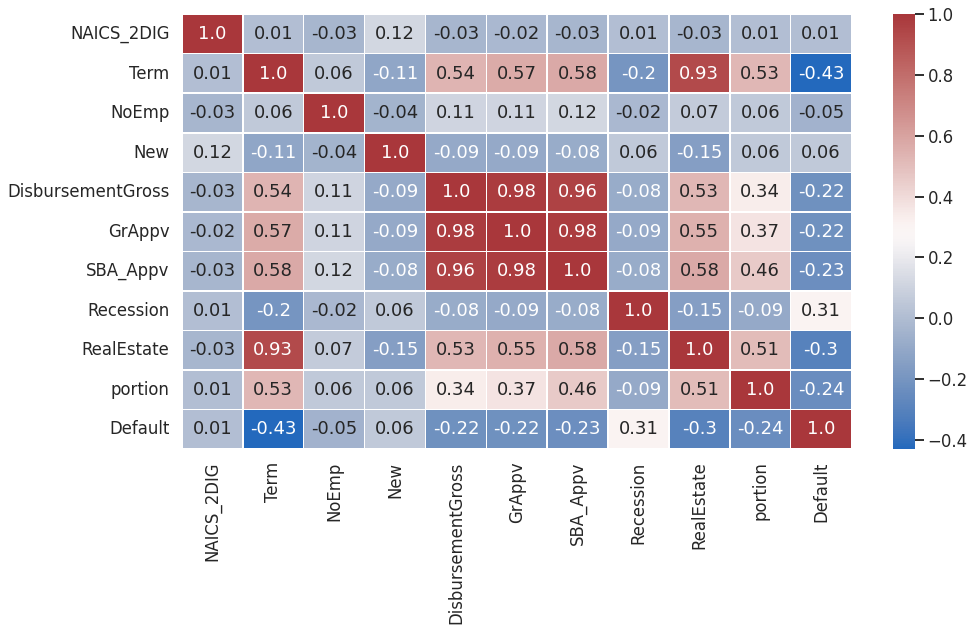

In [ ]:
# Correlation plot
fig, ax = plt.subplots(figsize=(15,8))
#pearson
sns.heatmap(np.round(pearson_corr, 2),
              annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax
              );

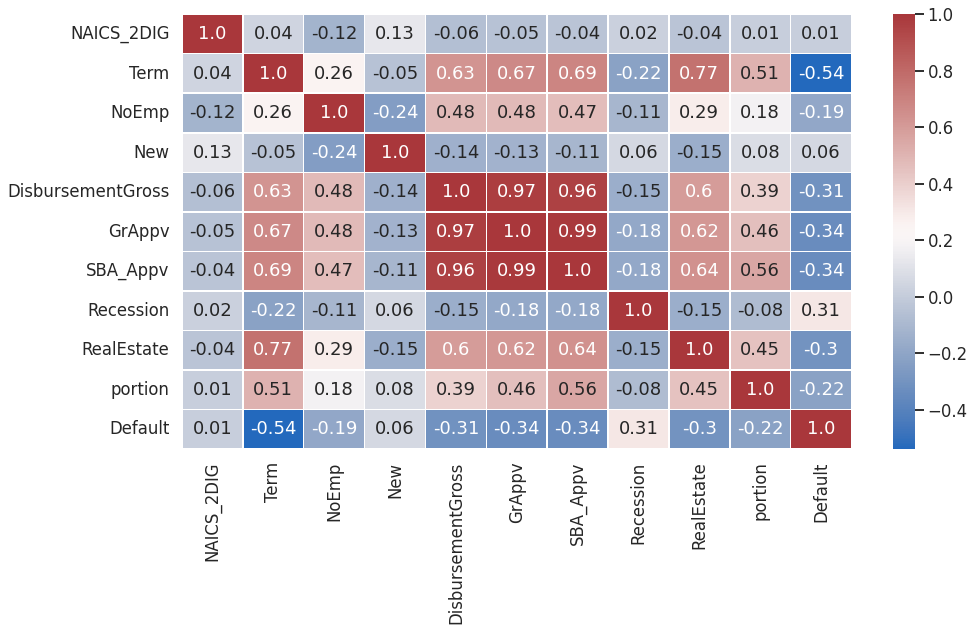

In [ ]:
#spearman
fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(np.round(spearman_corr, 2), square = False,
              annot = True, fmt = "", linewidths = .5,cmap ="vlag", ax = ax
              );

### **Data Preprocessing**


In [14]:
# Split data into Features and target 
target = 'Default'
X = df_tran.drop(columns = target)
y = df_tran[target]


print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (101841, 10)
Labels shape: (101841,)


In [15]:
# split the data into train, val and test set
def train_test_val_split(features, labels, split_train, split_val):

  # Split and get index
  train_idx_f, test_idx = next(split_train.split(features, labels))

  # first x and y train set
  X_train_f = features.iloc[train_idx_f]
  y_train_f = labels.iloc[train_idx_f]

  # X and y test set
  X_test = features.iloc[test_idx]
  y_test = labels.iloc[test_idx]

  # Second Split and get index
  train_idx, val_idx = next(split_val.split(X_train_f, y_train_f))

  # X and y train set (definitive)
  X_train = features.iloc[train_idx]
  y_train = labels.iloc[train_idx]

  # X and y validation set
  X_val = features.iloc[val_idx]
  y_val = labels.iloc[val_idx]

  return X_train, y_train, X_test, y_test, X_val, y_val

In [16]:
split_train = StratifiedShuffleSplit(n_splits = 1,
                                     test_size = 0.2,
                                     random_state = np.random.seed(42)
                                     )
split_val = StratifiedShuffleSplit(n_splits = 1,
                                     test_size = 0.25,
                                     random_state = np.random.seed(42)
                                     )

X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y,split_train, split_val)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (61104, 10)
X_val shape:(20368, 10)
X_test shape:(20369, 10)
y_train shape: (61104,)
y_val shape: (20368,)
y_test shape: (20369,)


In [ ]:
# OverSampling  method to unbalance data
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
def oversampling(alg, X, y):
    
    alg_over = alg(random_state = np.random.seed(42), n_jobs = -1)
  
    X_train_over, y_train_over = alg_over.fit_resample(X, y)
    
    return X_train_over, y_train_over

In [ ]:
X_train, y_train = oversampling(BorderlineSMOTE, X_train, y_train) 

print(f"X train over shape: {X_train.shape}")
print(f"y train over shape: {y_train.shape}")

### **Modelling**
- Base line:
 - LogisticRegression
-  Models:
   - RandomForestClassifier
   - ExtraTreeClassfier
   - XGBClassifier

- Models Performances:
   - Classification Report:
      - Accuracy
      - Presicion
      - Recall
      - F1-Score
      - AUC

- Hyperparameters Tuning (the best model):
  - Bayes Optimizer (Hyperotp)

- Final Model:
  - Predictions(inference) with the test set

  - Metrics:
     - Confusion Matrix
     - Roc-Auc curve

  


In [17]:
# Model Performance
from sklearn.metrics import log_loss
dict_df = {
    'Model':['Baseline', 'RandomForest', 'ExtraTrees', 'XGBoost'],
    'Log Loss':[0,0,0,0],
    'Accuracy':[0,0,0,0],
    'Precision':[0,0,0,0],
    'Recall':[0,0,0,0],
    'F1-Score':[0,0,0,0],
    'AUC':[0,0,0,0]
}
df_result = pd.DataFrame(dict_df, columns = ['Model','Log Loss','Accuracy', 'Precision', 'Recall','F1-Score','AUC'])

def model_results(model, y_val, y_pred):
  
  inx_models = df_result[df_result['Model'] == model].index

  df_result.loc[inx_models, 'Log Loss'] = log_loss(y_val, y_pred)
  df_result.loc[inx_models, 'Accuracy'] = accuracy_score(y_val, y_pred)
  df_result.loc[inx_models, 'Precision'] = precision_score(y_val, y_pred)
  df_result.loc[inx_models, 'Recall'] = recall_score(y_val, y_pred)
  df_result.loc[inx_models, 'F1-Score'] = f1_score(y_val, y_pred)
  df_result.loc[inx_models, 'AUC'] = roc_auc_score(y_val, y_pred)

  return (df_result)

#Funtion: performance of the model with the validation set
def model_performance_test(y_test, y_pred, y_pred_pro):
  ## Accuracy and roc_auc score
  print(f"Accuracy: {accuracy_score(y_test, y_pred)} \nRoc_Auc score: {roc_auc_score(y_test, y_pred)}\nF1-score: {f1_score(y_test, y_pred)}")

  ## Roc curve
  fpr, tpr, thr = roc_curve(y_test, y_pred_pro[:,1])
  
  ## define the figure and its size
  plt.figure(figsize =(15,5))
  layout = (1,2)
  
  # Axis
  cmd = plt.subplot2grid(layout,(0,0))
  rc = plt.subplot2grid(layout,(0,1))
  
  # Conision Matrix plot 
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = cmd)
  cmd.xaxis.set_ticklabels(["Not fraud:0", "Fraud:1"])
  cmd.yaxis.set_ticklabels(["Not fraud:0", "Fraud:1"])
  
  # Roc-Auc Curve plot
  rc.plot(fpr, tpr, color ='blue', linewidth = 5)
  rc.plot([0, 1],[0, 1], ls = '--', color = 'red', lw = .4)
  rc.set(xlabel = 'False Positive Rate',
       ylabel = 'True Positive Rate',
       xlim =[-.01, 1.01], ylim =[-.01, 1.01],
       title = 'ROC curve')
  
  plt.show()

#### **Baseline**

In [18]:
## LogisticRegression model
lr_model = LogisticRegression()
##Fit the model
lr_model.fit(X_train,y_train)

LogisticRegression()

In [19]:
bs_pred = lr_model.predict(X_val)

model_results('Baseline', y_val, bs_pred)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,6.981388,0.797869,0.644379,0.35774,0.460066,0.647574
1,RandomForest,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,ExtraTrees,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,XGBoost,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


#### **RandomForest Model**

In [20]:
## RandomForest 
model_rf = RandomForestClassifier(
  #  n_estimators = 1000,
  #  max_depth = 10,
#   criterion = 'entropy',
 #   class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [21]:
## model performance 
acc_train_rf = model_rf.score(X_train, y_train)
acc_val_rf = model_rf.score(X_val, y_val)

print(f"RandomForest Train Accuracy:{round(acc_train_rf,2)} \nRandomForest Validation Accuracy: {round(acc_val_rf,2)}")

RandomForest Train Accuracy:1.0 
RandomForest Validation Accuracy: 0.95


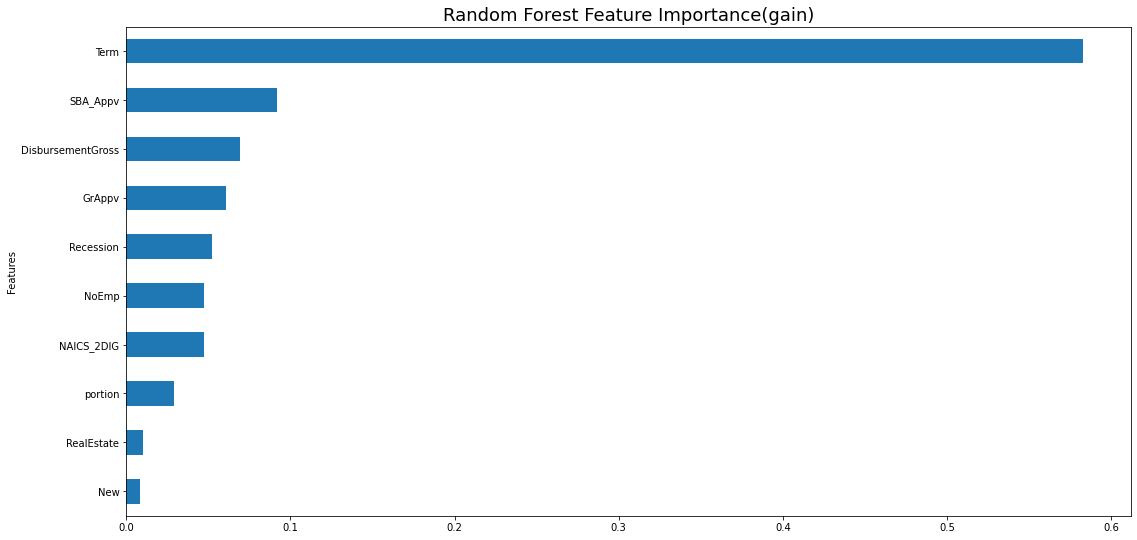

In [22]:
## RandomForest Feature importance
fea_imp_rf = pd.Series(model_rf.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_rf.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance(gain)', fontsize = 18);

In [23]:
## RandomForest Classification report with the validation set
y_pred_rf = model_rf.predict(X_val)

model_results('RandomForest', y_val, y_pred_rf)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,6.981388,0.797869,0.644379,0.357740,0.460066,0.647574
1,RandomForest,1.848375,0.946485,0.888210,0.889659,0.888934,0.927080
2,ExtraTrees,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### **ExtraTrees Model**

In [24]:
extree_model = ExtraTreesClassifier(
#    n_estimators = 1000,
#    max_depth = 10,
#    criterion = 'entropy',
#    class_weight = 'balanced',
#    random_state = 100,
#    n_jobs = -1
)
extree_model.fit(X_train, y_train)

ExtraTreesClassifier()

In [25]:
## model performance 
acc_train_et = extree_model.score(X_train, y_train)
acc_val_et = extree_model.score(X_val, y_val)

print(f"ExtraTrees  Train Accuracy:{round(acc_train_et,2)} \nExtraTrees Validation Accuracy: {round(acc_val_et,2)}")

ExtraTrees  Train Accuracy:1.0 
ExtraTrees Validation Accuracy: 0.94


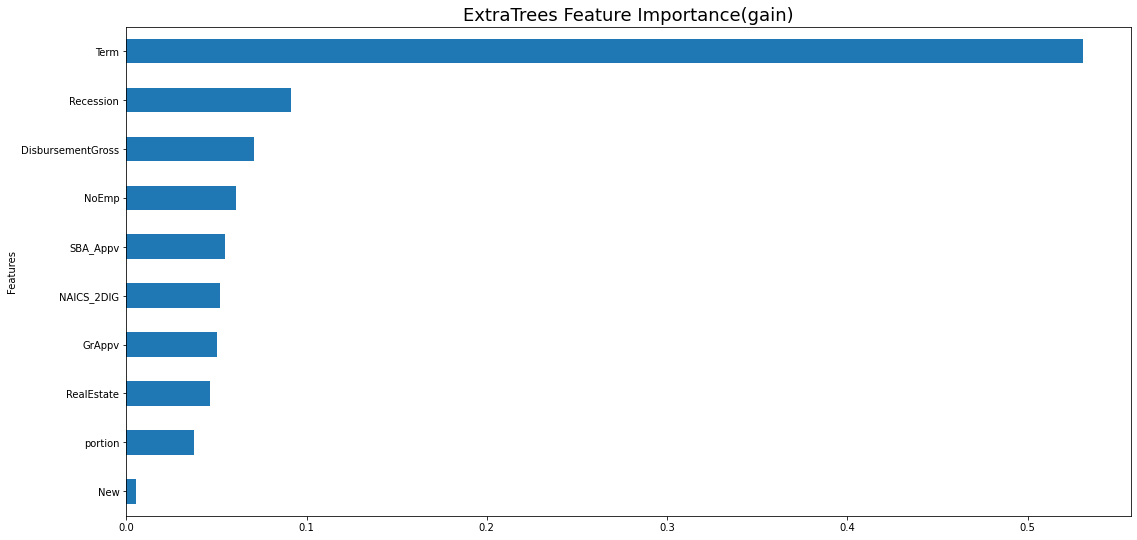

In [26]:
## RandomForest Feature importance
fea_imp_et = pd.Series(extree_model.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_et.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('ExtraTrees Feature Importance(gain)', fontsize = 18);

In [27]:
## Extratree model performnace
y_pred_et = extree_model.predict(X_val)

model_results('ExtraTrees', y_val, y_pred_et)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,6.981388,0.797869,0.644379,0.357740,0.460066,0.647574
1,RandomForest,1.848375,0.946485,0.888210,0.889659,0.888934,0.927080
2,ExtraTrees,2.170567,0.937156,0.876220,0.860494,0.868286,0.910977
3,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### **XGB Model**

In [ ]:
# ## Scale pos weight definition
# scale_pos_weight = len(df[df['Default'] == 0]) / len(df[df['Default'] == 1])
#                           objective = 'binary:logistic',
#                           tree_method = 'gpu_hist',
#                           scale_pos_weight = scale_pos_weight,
#                           subsample = 0.8,
#                           colsample_bytree = 0.8,
#                           max_depth = 10,
#                           learning_rate = 0.01,
#                           n_estimators = 1000,

In [28]:
## XGBClassifier
model_xgb = xgb.XGBClassifier(seed = 42)

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [29]:
## Model performance with the train a validation set
acc_train_xgb = model_xgb.score(X_train, y_train)
acc_val_xgb = model_xgb.score(X_val, y_val)

print(f"XGB Train Accuracy:{round(acc_train_xgb,2)} \nXGB Validation Accuracy: {round(acc_val_xgb,2)}")

XGB Train Accuracy:0.97 
XGB Validation Accuracy: 0.95


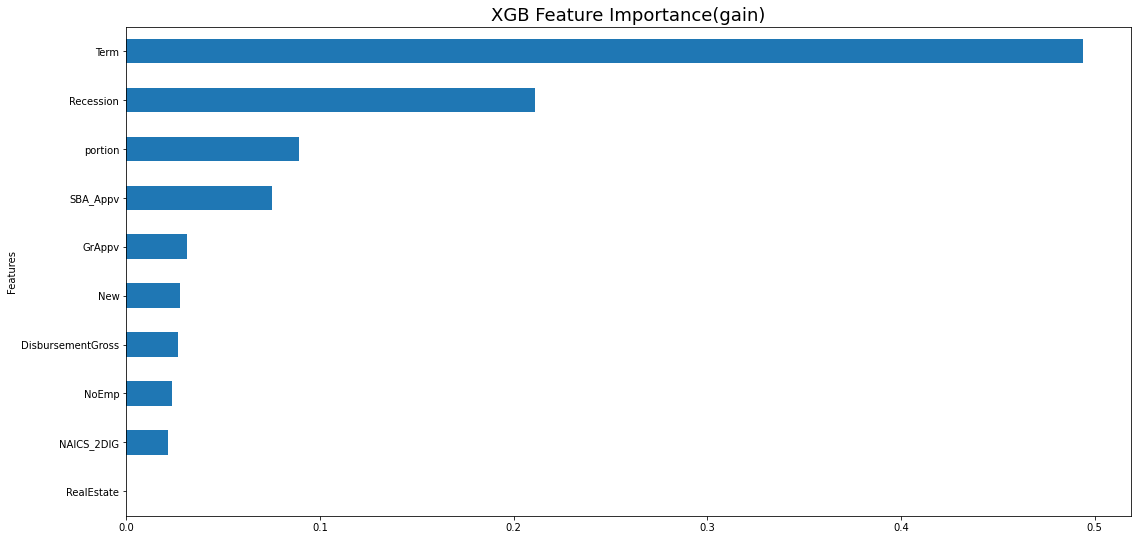

In [30]:
## Feature importance
fea_imp_xgb = pd.Series(model_xgb.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_xgb.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Feature Importance(gain)', fontsize = 18);

In [31]:
## Xgb Classification report with the validation set
y_pred_xgb = model_xgb.predict(X_val)

model_results('XGBoost', y_val, y_pred_xgb)

,Model,Log Loss,Accuracy,Precision,Recall,F1-Score,AUC
0,Baseline,6.981388,0.797869,0.644379,0.357740,0.460066,0.647574
1,RandomForest,1.848375,0.946485,0.888210,0.889659,0.888934,0.927080
2,ExtraTrees,2.170567,0.937156,0.876220,0.860494,0.868286,0.910977
3,XGBoost,1.582141,0.954193,0.905599,0.903936,0.904767,0.937031


#### **Hyperparameters Tuning (XGB Model)**

In [32]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

# Number of folder to split the training data
strkf = StratifiedKFold(n_splits = 4)

## Space of hyperparameters
space = {
         'tree_method':'gpu_hist',
         'objective': 'binary:logistic',
         'subsample': hp.uniform('subsample', 0.5, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
         'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
         'learning_rate': hp.loguniform('learning_rate', -8, 0),
         'min_child_weight': hp.quniform('min_child_weight',3, 10, 1),
         'max_depth': scope.int(hp.uniform('max_depth', 6, 20)),
         'gamma': hp.loguniform('gamma', -10, 3),
         'reg_alpha': hp.loguniform('alpha', -10, 2),
         'reg_lambda': hp.loguniform('reg_lambda', -10, 2),
         'n_estimators': scope.int(hp.uniform('n_estimators', 100, 500)),
         #'eval_metric': 'auc',
         'seed': 42, 
         
    }


def objective(param):

  model = xgb.XGBClassifier(**param)

  roc_auc = cross_val_score(model, X_train, y_train, scoring = "roc_auc", cv = strkf).mean() 
 
  return {'loss': -roc_auc, 'status': STATUS_OK }

    
trials = Trials()

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 70,
            trials = trials
            )
best

100%|██████████| 70/70 [11:07<00:00,  9.54s/it, best loss: -0.985147284824631]


{'alpha': 0.007647716477983933,
 'colsample_bylevel': 0.8114106499935337,
 'colsample_bytree': 0.7357723837667357,
 'gamma': 0.13024906933441674,
 'learning_rate': 0.029857652937530406,
 'max_depth': 12.417945477864295,
 'min_child_weight': 3.0,
 'n_estimators': 219.60374984177875,
 'reg_lambda': 1.0863905985734745,
 'subsample': 0.8721681137895895}

#### **Final Model**

In [33]:
### Train final model
final_model = xgb.XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    learning_rate = best['learning_rate'],
    max_depth = int(best['max_depth']),
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    colsample_bylevel = best['colsample_bylevel'],
    min_child_weight = int(best['min_child_weight']),
    reg_lambda = best['reg_lambda'],
    reg_alpha = best['alpha'],
    gamma = int(best['gamma']),
    n_estimators = int(best['n_estimators']),
    seed = 42

)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8114106499935337, colsample_bynode=1,
              colsample_bytree=0.7357723837667357, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.029857652937530406,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=12,
              max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=219, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.007647716477983933, reg_lambda=1.0863905985734745, ...)

##### **Evaluate the Final Model with the test set**

##### Predictions

In [34]:
y_pred = final_model.predict(X_test)
y_pred_pro = final_model.predict_proba(X_test)

##### Model Performance
- Metrics:
 - Acuraccy
 - Roc-Auc curve
 - Confusion Matrix

Accuracy: 0.9615592321665276 
Roc_Auc score: 0.9437705441108901
F1-score: 0.9135856969429422


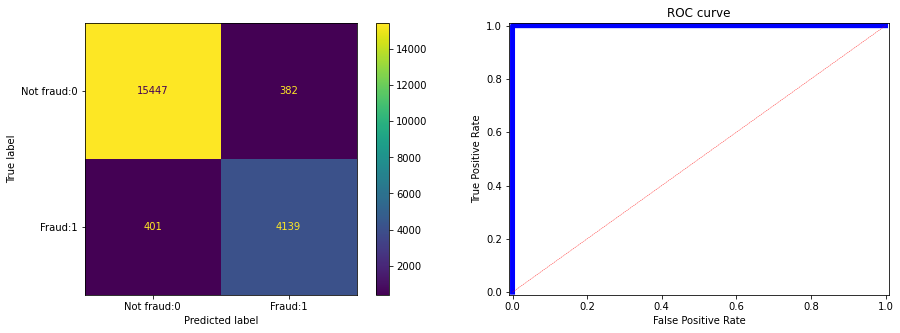

In [35]:
## Final model performance
model_performance_test(y_pred, y_test, y_pred_pro)

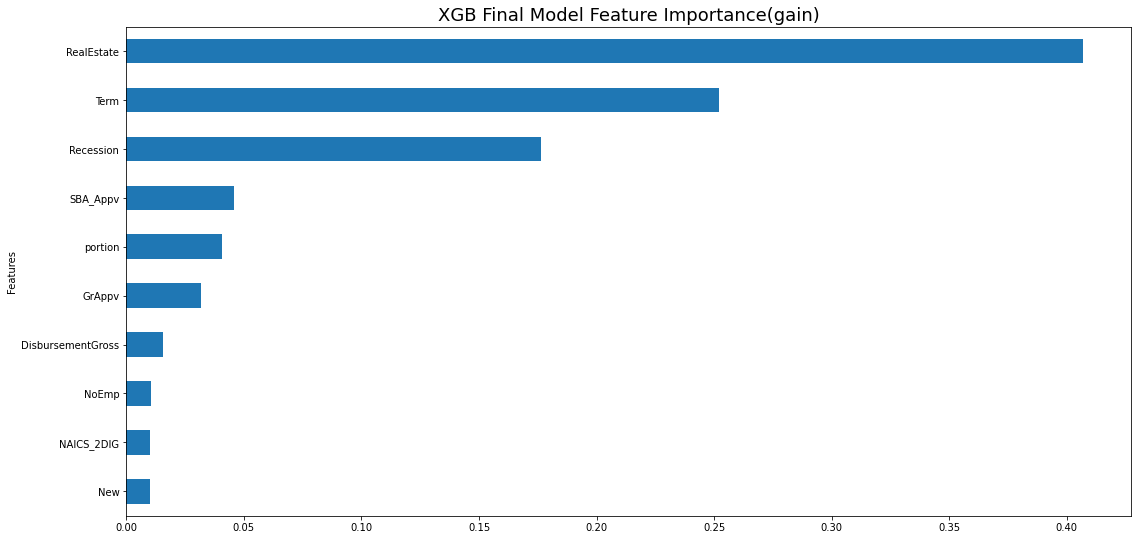

In [36]:
## Feature importance
fea_imp_xgb_h = pd.Series(final_model.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_xgb_h.sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Final Model Feature Importance(gain)', fontsize = 18);

##### **Serialization**

In [37]:
with open('LD_xgb_Model-0.0.1.pkl', 'wb') as f:
  joblib.dump(final_model, f)